In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gzip -d HIGGS.csv.gz
!rm -f HIGGS.csv.gz

--2021-06-12 05:58:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  95.8MB/s    in 29s     

2021-06-12 05:59:00 (92.4 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [2]:
"""
Description:
------------
- 21 low-level features, 7 high level features
- Low-level features > Kinematic properties measured by particle detectors in the accelerator.
- High-level features > Are a function of low-level features.

"""
d = pd.read_csv('HIGGS.csv', header=None, nrows=11000000*0.3)

In [3]:
col_names = "label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb"
cols = col_names.split(",")
cols = list(map(lambda name: name.strip(), cols))

d.columns = cols

In [4]:
d # 1: signal, 0: background

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299995,0.0,0.873136,0.882362,0.869329,1.624510,-1.587693,1.741178,-0.342645,0.249075,0.000000,1.597086,-0.510882,-1.695211,2.214872,0.884956,0.001993,-0.627605,2.548224,1.390098,1.207133,-0.623988,0.000000,1.062964,0.872383,1.321202,1.342966,1.089911,1.009345,0.957290
3299996,0.0,1.184984,-0.853251,0.737827,0.164765,1.600670,1.168450,1.708121,-1.599317,0.000000,1.628184,-0.506025,-0.331437,1.107436,0.516151,1.239932,1.253052,0.000000,0.859227,0.815706,0.556415,1.550981,0.795434,0.874592,0.982494,1.043210,1.165096,1.512474,1.308331
3299997,0.0,2.121441,0.710943,1.501871,0.402602,0.806457,0.489183,-0.765473,-0.391331,0.000000,0.717146,0.654766,0.123627,2.214872,0.433082,-1.360649,1.525982,0.000000,1.203405,1.262932,-0.494136,0.000000,0.872533,0.973514,0.989814,0.598236,0.507509,0.629242,0.808271
3299998,1.0,1.482008,0.029165,-0.063495,0.911773,0.573383,0.674229,-1.120966,1.419362,2.173076,1.300205,-0.008682,-1.590903,2.214872,0.469611,0.972318,-0.688072,0.000000,0.944663,0.332669,0.821108,0.000000,0.760814,0.886329,0.991019,1.259996,0.995077,1.070662,0.884255


In [5]:
print(f"Signal events: {len(d[d['label'] == 1.0])}")
print(f"Background events: {len(d[d['label'] == 0.0])}")

Signal events: 1748194
Background events: 1551806


In [6]:
# Ensure all types are `float` and not `object`
d.dtypes

label                       float64
lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

In [7]:
d = d.sample(frac=1).reset_index(drop=True)  # Shuffle

In [8]:
d["label"] = d.label.astype("category")

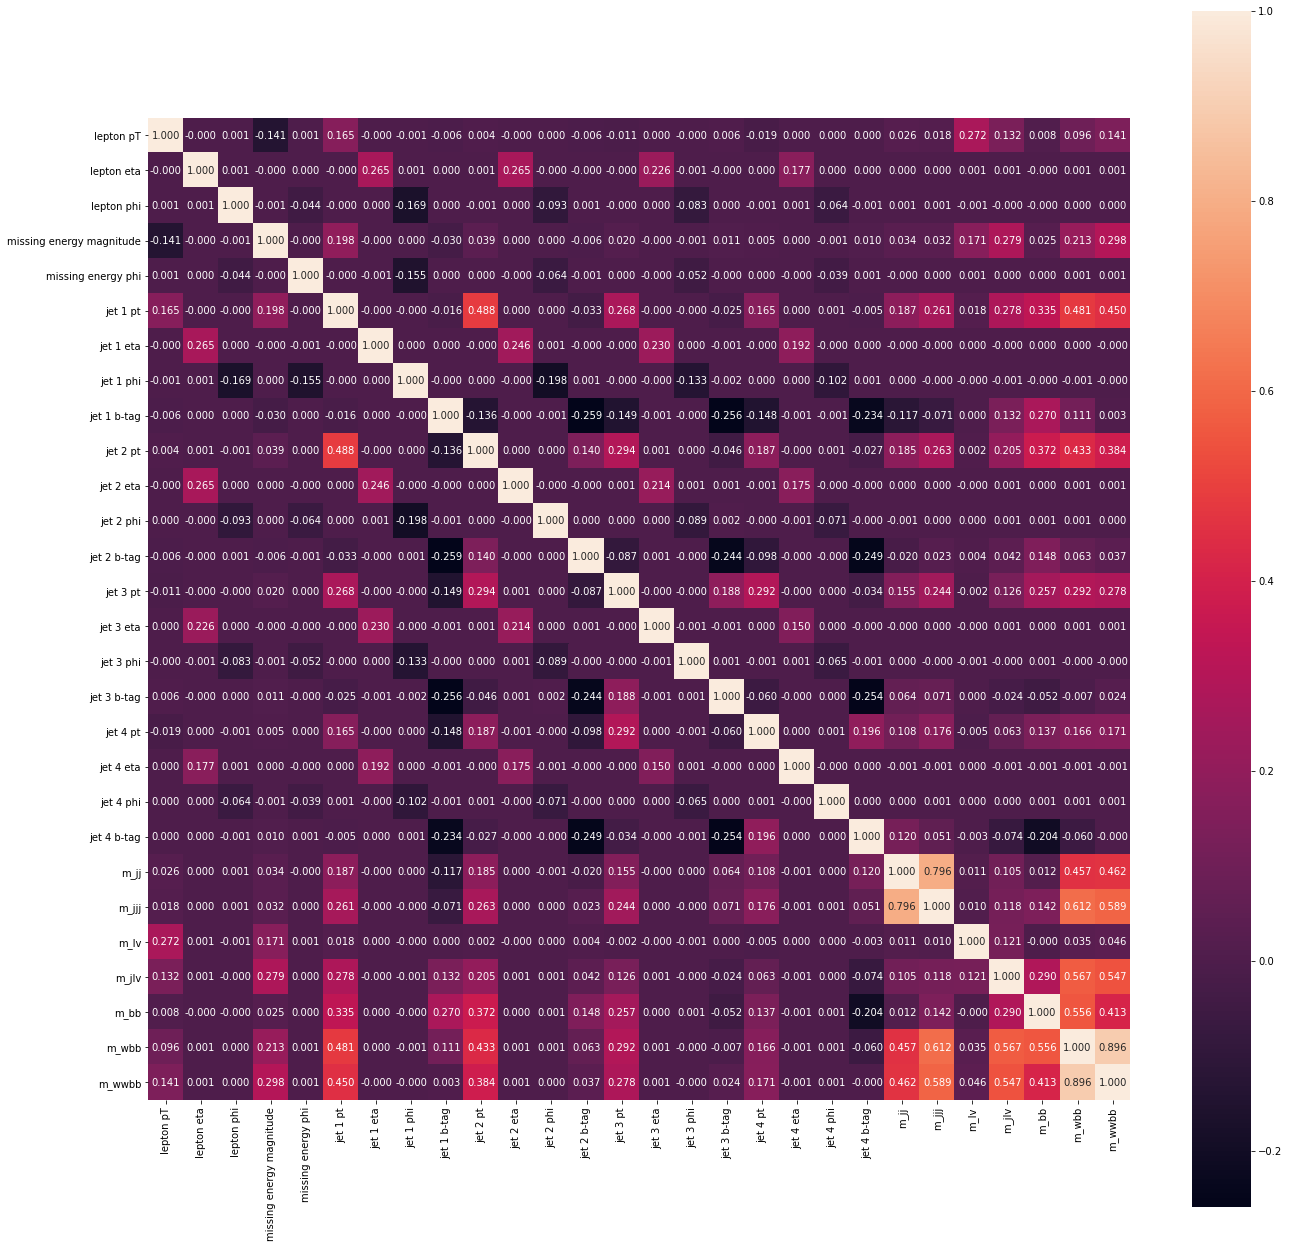

In [9]:
fig = plt.figure(figsize=(22, 22))
sns.heatmap(d.corr(), annot=True, square=True, fmt=".3f");

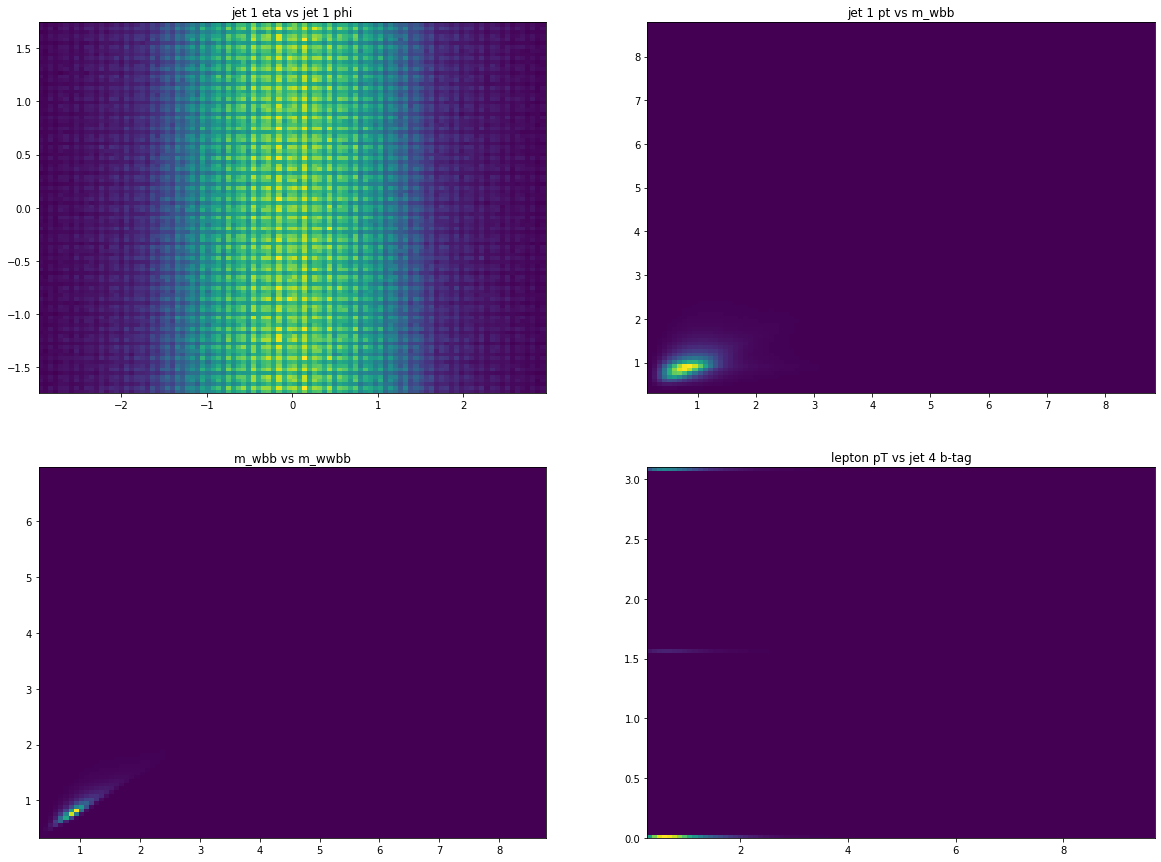

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

counts, xedges, yedges, im = axes[0, 0].hist2d(d["jet 1 eta"], d["jet 1 phi"], bins=100)
axes[0, 0].set_title("jet 1 eta vs jet 1 phi");

counts, xedges, yedges, im = axes[0, 1].hist2d(d["jet 1 pt"], d["m_wbb"], bins=100)
axes[0, 1].set_title("jet 1 pt vs m_wbb");

counts, xedges, yedges, im = axes[1, 0].hist2d(d["m_wbb"], d["m_wwbb"], bins=100)
axes[1, 0].set_title("m_wbb vs m_wwbb");

counts, xedges, yedges, im = axes[1, 1].hist2d(d["lepton pT"], d["jet 4 b-tag"], bins=100)
axes[1, 1].set_title("lepton pT vs jet 4 b-tag");

In [11]:
d.isnull().values.any() # Check if any null values in the dataset

False

In [12]:
from util import prepare_df, split_data, train_bdt, plot_predictions, plot_roc

In [13]:
df = prepare_df(d, which_feats="low_level")
train, test = split_data(df, which_feats="low_level")

Defining hyperparameters and tuning...

In [14]:
# Define parameters for XGBoost classifier.
params = {}

# The values have been selected using cross validation on a subset of the data. Analysis in cv_analysis.md.

# Booster parameters
params["eta"]              = 0.01 # Learning rate
params["max_depth"]        = 12  # Maximum depth of tree
params["subsample"]        = 0.8 # Fraction of events to train the tree on
params["colsample_bytree"] = 0.8 # Fraction of features to train the tree on
params["min_child_weight"] = 13 # Minimum weight required to create a new node in the tree

# Learning parameters
params["objective"]   = "binary:logistic" # Objective function (two classes for which a score needs to be output)
params["eval_metric"] = "error"           # Evaluation metric for cross validation
params = dict(list(params.items()) + [("eval_metric", "log-loss"), ("eval_metric", "rmse")])

In [15]:
params

{'colsample_bytree': 0.8,
 'eta': 0.01,
 'eval_metric': 'rmse',
 'max_depth': 12,
 'min_child_weight': 13,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [16]:
# num_boost_round = 300 # Set to high enough value initially, to ensure the optimized value after cross validation is under this limit.

In [17]:
booster, predictions, evaluation = train_bdt(train, test, params, num_trees=200, which_feats="low_level")

In [18]:
print(evaluation)

[0]	eval-rmse:0.465280


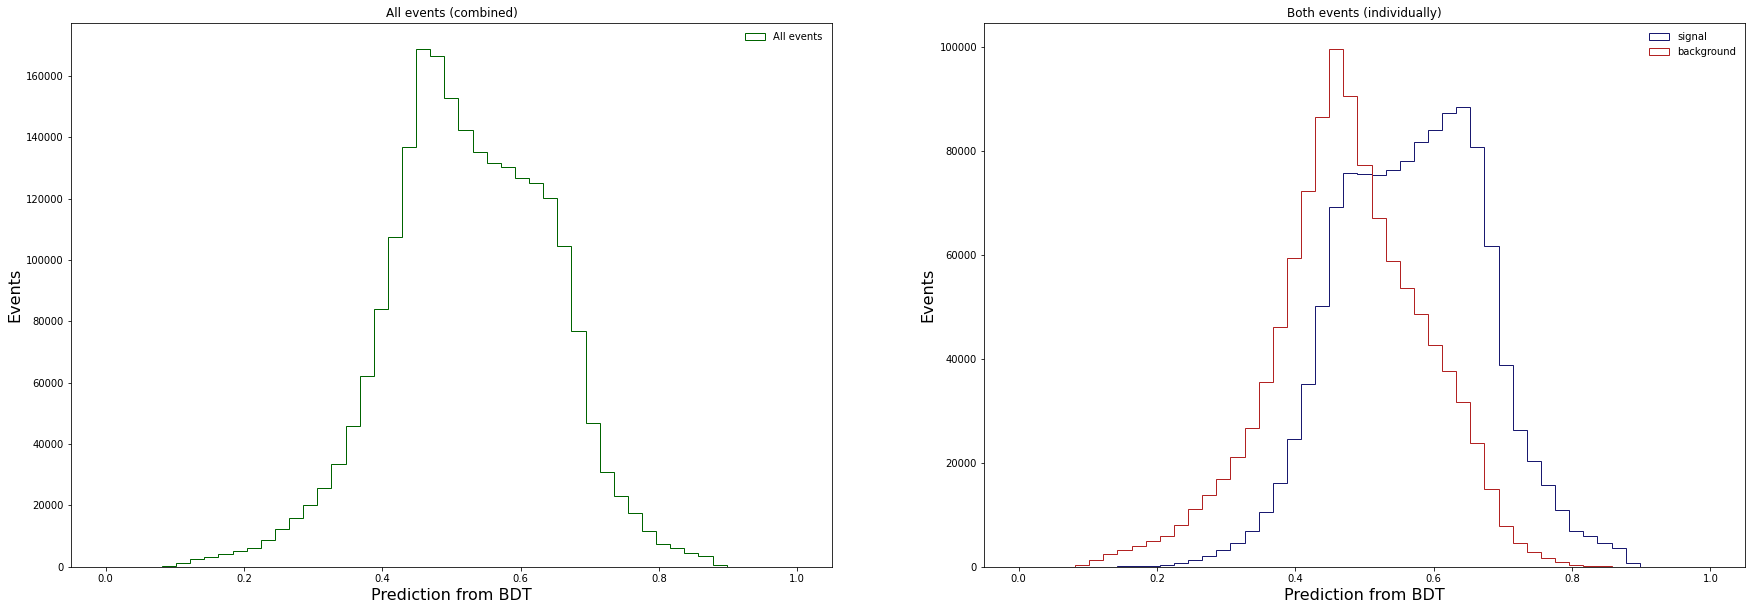

In [19]:
plot_predictions(predictions, test)

In [20]:
!pip install plot-metric

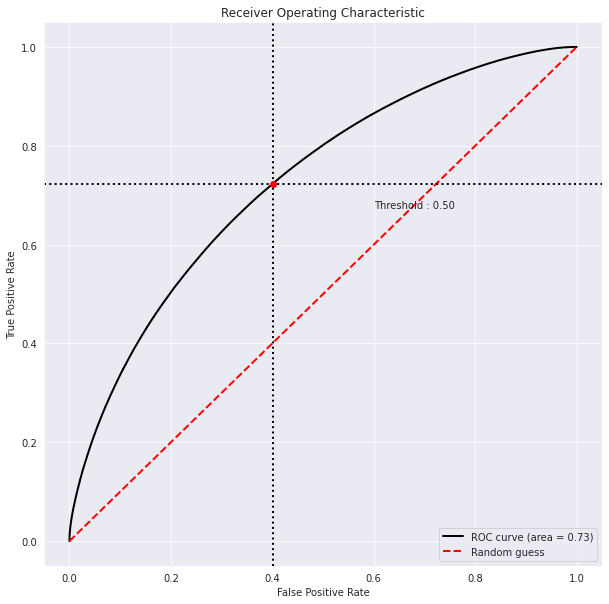

In [21]:
plot_roc(predictions, test)

**AUC = 0.73**

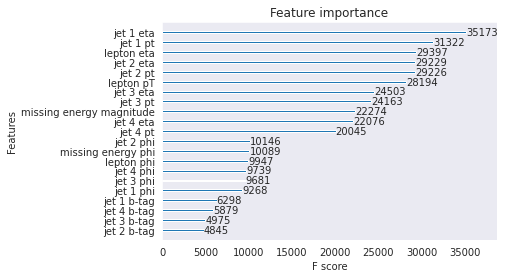

In [22]:
xgb.plot_importance(booster, grid=False);

`jet 1 eta` has the highest F1-score and is the most important feature among all the low-level features.

Using high level features

In [23]:
df_high = prepare_df(d, which_feats="high_level")
train_high, test_high = split_data(df_high, which_feats="high_level")

In [24]:
booster_high, predictions_high, evaluation_high = train_bdt(train_high, test_high, params, which_feats="high_level")

In [25]:
print(evaluation_high)

[0]	eval-rmse:0.449697


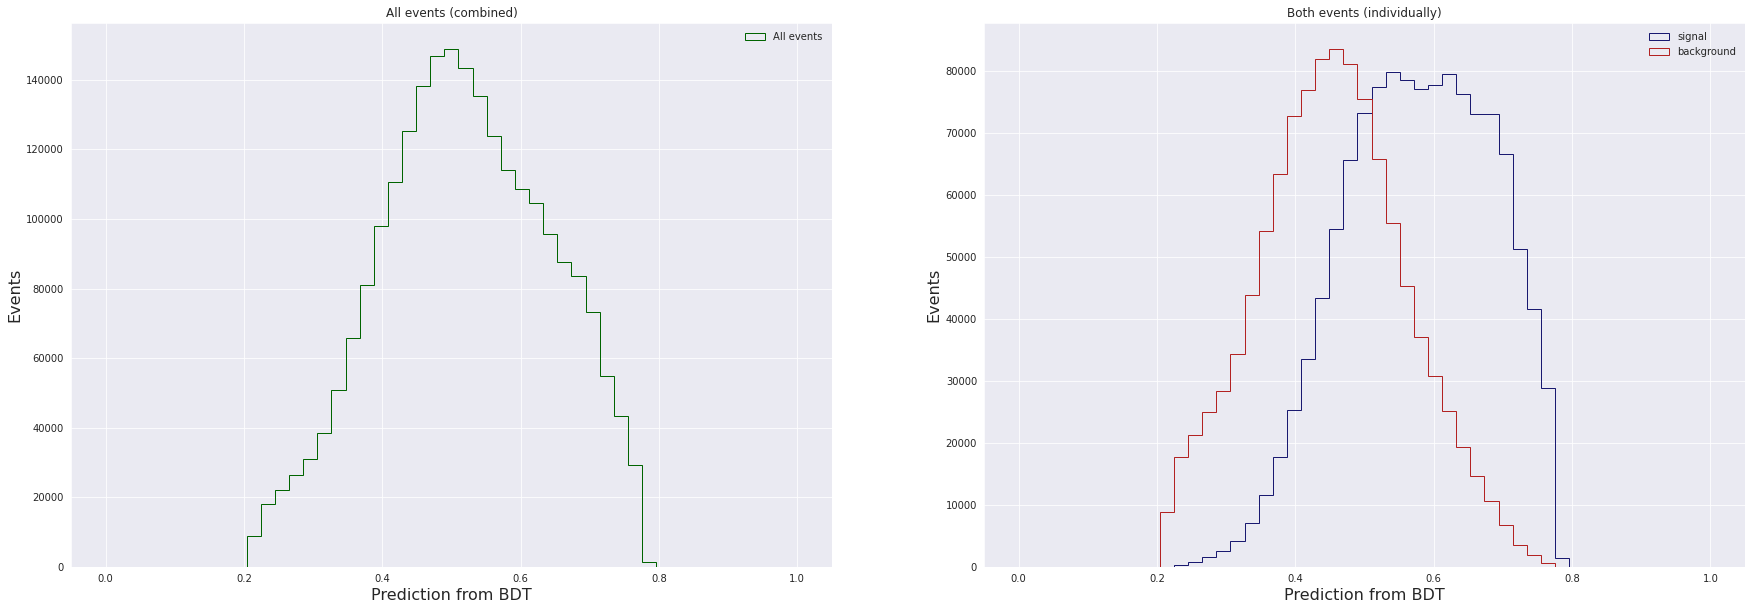

In [26]:
plot_predictions(predictions_high, test_high)

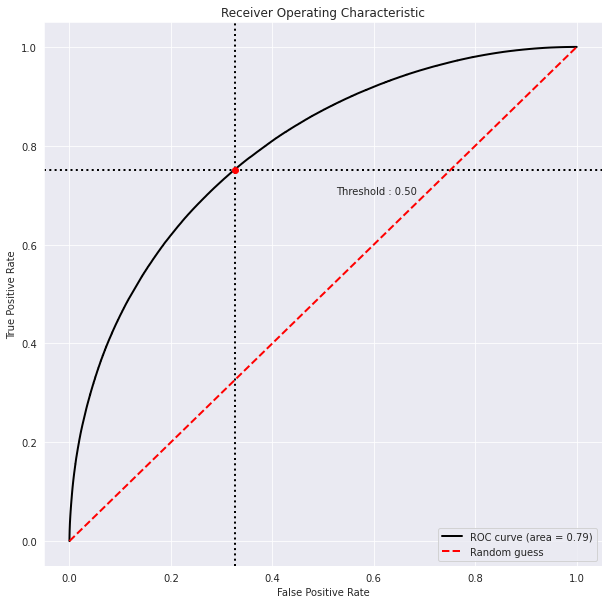

In [27]:
plot_roc(predictions_high, test_high)

**AUC = 0.79**

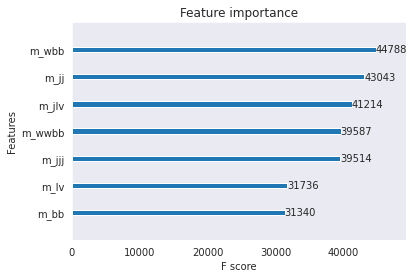

In [28]:
xgb.plot_importance(booster_high, grid=False);

It seems high level features outperform low level features in terms of model performance in testing.